# Trip Advisor Reviews Sentiment Analysis and Prediction

Para esse projeto será utilizada a base de dados do [Kaggle](https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews) disponível publicamente.

Essa base de dados será usada para explorar os aspectos do hotel e prever a classificação de cada avaliação.

**Para mais informações sobre a base de dados**:

Alam, M. H., Ryu, W.-J., Lee, S., 2016. Joint multi-grain topic sentiment: modeling semantic aspects for online reviews. Information Sciences 339, 206–223

[DOI](https://doi.org/10.5281/zenodo.1219899)

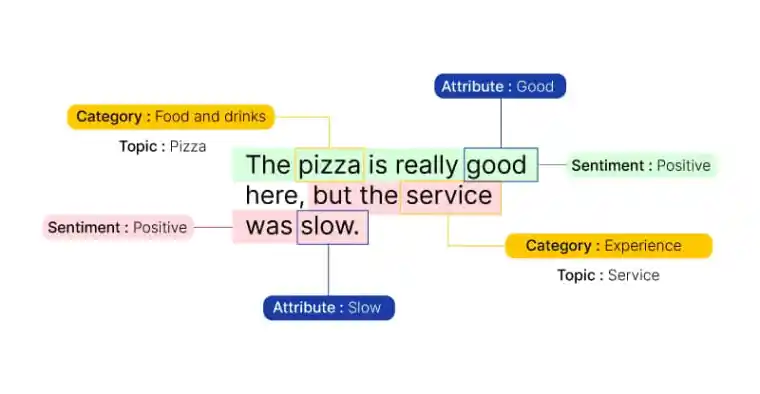

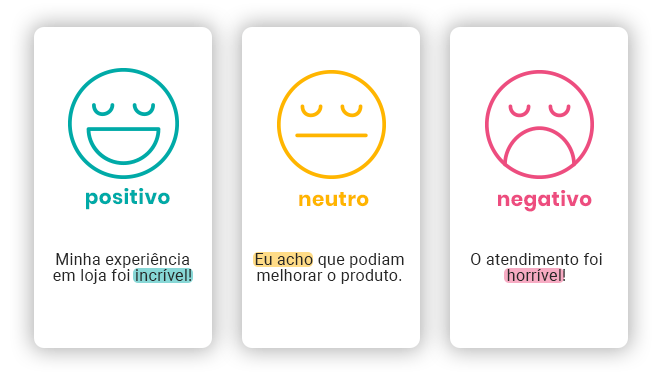

A análise de sentimento é o processo de detecção de sentimentos positivos ou negativos no texto. É frequentemente usado por empresas para **detectar sentimentos em dados sociais, avaliar a reputação da marca e entender os clientes**.

# Por que a análise de sentimentos é importante?

A análise de sentimento é extremamente importante porque ajuda as empresas a entender rapidamente as opiniões gerais de seus clientes. Ao classificar automaticamente o sentimento por trás de comentários, conversas de mídia social e muito mais, você pode tomar decisões mais rápidas e precisas.

Estima-se que 90% dos dados do mundo são desestruturados, ou seja, desorganizados. Enormes volumes de dados de negócios não estruturados são criados todos os dias: e-mails, tíquetes de suporte, chats, conversas em mídias sociais, pesquisas, artigos, documentos, etc). Mas é difícil analisar o sentimento de maneira oportuna e eficiente.

# Algumas Aplicações da Análise de Sentimentos

As aplicações da análise de sentimento são infinitas e podem ser aplicadas a qualquer setor, desde finanças e varejo até hotelaria e tecnologia. Abaixo, listamos algumas das formas mais populares de uso da análise de sentimento nos negócios:

- Monitoramento de mídia social
- Monitoramento de marca
- Voice of Customer (VoC)
- Atendimento ao Cliente
- Pesquisa de mercado

In [2]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.12


In [3]:
# Imports
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import spacy
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV 
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score,roc_curve,auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark --iversions

pandas    : 1.4.2
seaborn   : 0.11.2
spacy     : 3.5.2
matplotlib: 3.5.1
plotly    : 5.6.0
numpy     : 1.21.5
nltk      : 3.7



**Stopwords (palavras de parada)** são palavras muito comuns que de forma geral não transmitem informações relevantes para o significado de um texto. _Ex: artigo, preposições e pronomes_.

Vamos baixar o pacote stopwords da biblioteca nltk (Natural Language Toolkit) para remover essas palavras comuns para facilitar o processo de identificação de **palavras-chave**.

In [5]:
# Download do pacote "stopwords" 
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#  Pipeline de Análise de sentimento

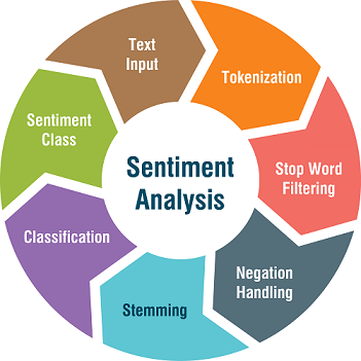

In [6]:
# Carregar dados
df = pd.read_csv('tripadvisor_hotel_reviews.csv')

# Amostra dos dados
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [7]:
# Shape
df.shape

(20491, 2)

In [8]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [9]:
# Verificando valores nulos
df.isnull().sum()

Review    0
Rating    0
dtype: int64

In [10]:
# Verificando valores de classficação(rating)
df["Rating"].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

In [11]:
# Verifcando a existência de espaços vazios
df.loc[df["Review"] == ""]

,Review,Rating


# Separando e atribuindo rótulos (positivo, neutro e negativo)

In [12]:
positive = [5]
negative = [1, 2]
neutral = [3, 4]

def sentiment_encoding (rating):
    if rating in positive:
        return 2
    elif rating in negative:
        return 0
    else:
        return 1          

In [13]:
# Criando uma nova coluna que recebe a aplicação da função
df["Sentiment"] = df["Rating"].apply(sentiment_encoding)
df.head()

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,1
3,"unique, great stay, wonderful time hotel monac...",5,2
4,"great stay great stay, went seahawk game aweso...",5,2


# Análise de avaliações positivas, neutras e negativas

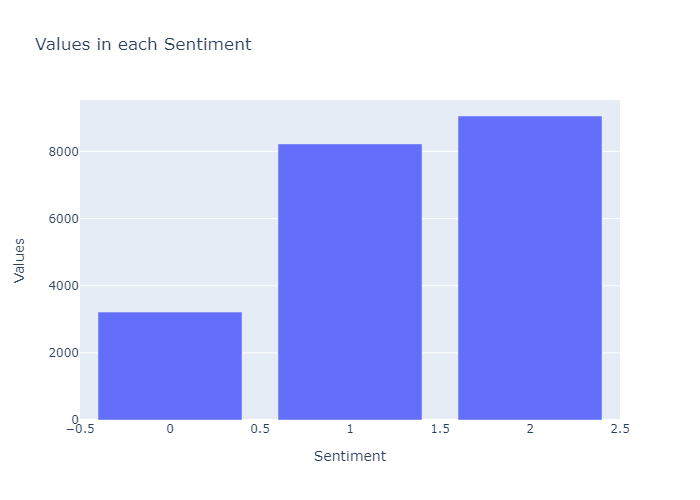

In [16]:
fig = go.Figure(
    [go.Bar(
        x = df.Sentiment.value_counts().index,
        y = df.Sentiment.value_counts().tolist())])

fig.update_layout(
    title = "Values in each Sentiment",
    xaxis_title = "Sentiment",
    yaxis_title="Values")

fig.show('png')

# Pré-processamento de texto  
1. Tokenização (Tarefa de cortar um texto em pedaços chamados tokens e, ao mesmo tempo, jogar fora alguns caracteres, como pontuação) 
2. Remoção de pontuação  
3. Remoção de palavras irrelevantes  
4. Removendo tags HTML  
5. Converter todas as letras de uma palavra para minúsculas 

In [17]:
# Carregando lista de stopwords em inglês
stopwords_list = set(stopwords.words("english"))

# Carregando lista de caracteres de pontuação
punctuations = """!()-![]{};:,+'"\,<>./?@#$%^&*_~Â"""

In [18]:
def review_parse(review):
    splitReview = review.split()
    parsedReview = " ".join([word.translate])

In [19]:
# Função para receber e analisar a "review", dividir em palavas e retirar a pontuação
def review_parse(review):
    splitReview = review.split()
    parsedReview = " ".join([word.translate(str.maketrans('', '', punctuations)) + " " for word in splitReview])
    return parsedReview 

# Função para limpar texto, remover as palavras que não são letras e as palavras que estão na lista de stopwords
def clean_review(review):
    clean_words = []
    splitReview = review.split()
    for word in splitReview:
        if word.isalpha() and word not in stopwords_list:
            clean_words.append(word.lower())
    clean_review = " ".join(clean_words)
    return clean_review

In [20]:
# Analisa todas as reviews quanto à pontuação e adiciona a uma nova coluna
df["Review"] = df["Review"].apply(review_parse).apply(clean_review) 
df.head()

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms experience hotel monaco seattle goo...,3,1
3,unique great stay wonderful time hotel monaco ...,5,2
4,great stay great stay went seahawk game awesom...,5,2


In [21]:
# Criando uma lista contendo as 7000 primeiras linhas da colunas "Review"
docs = list(df['Review'])[:7000]

Uma **matriz TF-IDF (Term Frequency-Inverse Document Frequency ou frequência do termo–inverso da frequência nos documentos)** é uma representação matemática de um conjunto de documentos textuais que possibilita quantificar a importância relativa de cada termo em relação ao conjunto de documentos. Ela é utilizada em processamento de linguagem natural e mineração de texto para identificar palavras-chave importantes em um documento.

Estamos preparando os dados para a etapa de aprendizagem de maquina.

In [22]:
#Criando uma matriz TF-IDF

# Criando objeto que será utilizado para calcular a matriz TF-IDF
tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_features = 20000) 
 
# realiza o fit e a transformação do texto
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(docs)

In [23]:
# Analisado as palavras usados no vetorizador
tfidf_vectorizer.get_feature_names_out()

array(['aa', 'aaa', 'aarp', ..., 'zum', 'zumo', 'zurich'], dtype=object)

In [24]:
# Representação numérica dos textos 
X = tfidf_vectorizer_vectors.toarray()

#  Cria o array Y contendo os valores da coluna 'Sentiment' dos primeiros 7000 registros
Y = df['Sentiment'][:7000]

In [25]:
# Número de palavras que foram extraídas
len(X[0])

20000

# Divide os dados em treinamento e validação

In [26]:
X_train,X_test,y_train,y_test=train_test_split(X, Y, test_size=0.2, random_state=123, stratify=Y)

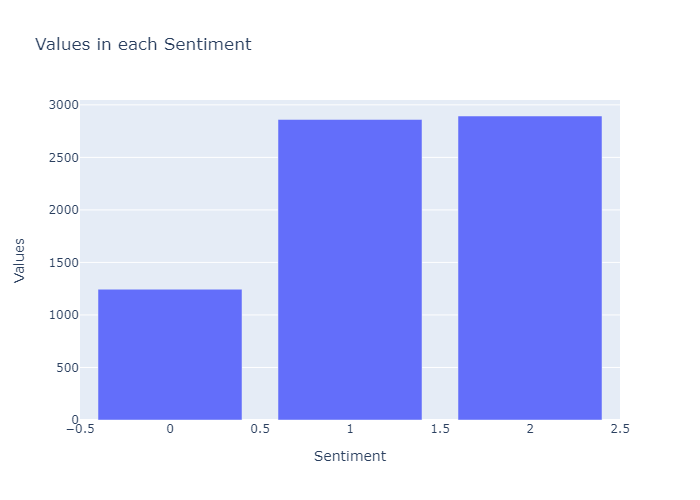

In [27]:
fig = go.Figure([go.Bar(x=Y.value_counts().index, y=Y.value_counts().tolist())])

fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")

fig.show('png')

In [28]:
# Normalização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Decision Tree Classifier

In [29]:
dt = DecisionTreeClassifier(random_state=123)

dt.fit(X_train_scaled,y_train)

y_pred_test = dt.predict(X_test_scaled)

print("Training Accuracy score: "+str(round(accuracy_score(y_train,dt.predict(X_train_scaled)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,dt.predict(X_test_scaled)),4)))

Training Accuracy score: 1.0
Testing Accuracy score: 0.5879


In [30]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.59      0.56      0.57       249
     neutral       0.57      0.59      0.58       572
    negative       0.61      0.60      0.60       579

    accuracy                           0.59      1400
   macro avg       0.59      0.58      0.58      1400
weighted avg       0.59      0.59      0.59      1400



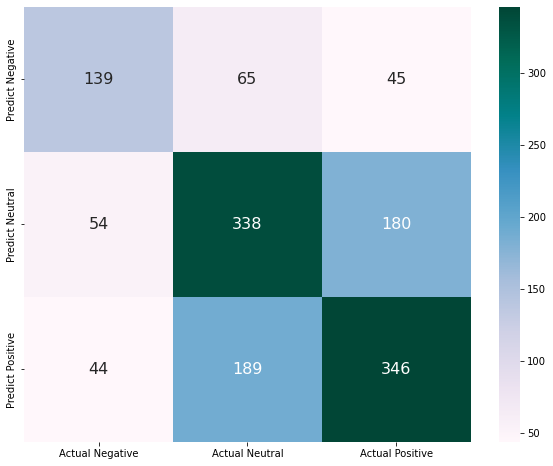

In [31]:
# Matriz de confusão
fig, ax = plt.subplots(figsize=(10, 8))

cm = confusion_matrix(y_test, y_pred_test)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])

# Heatmap
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='PuBuGn', annot_kws={"fontsize":16})
plt.show()

# Naive Bayes

In [32]:
gnb = GaussianNB()

gnb.fit(X_train_scaled, y_train)

y_pred_train = gnb.predict(X_train_scaled)
y_pred_test = gnb.predict(X_test_scaled)

print("Training Accuracy score: "+str(round(accuracy_score(y_train,dt.predict(X_train_scaled)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,dt.predict(X_test_scaled)),4)))

Training Accuracy score: 1.0
Testing Accuracy score: 0.5879


In [33]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.30      0.43      0.35       249
     neutral       0.46      0.40      0.43       572
    negative       0.49      0.45      0.47       579

    accuracy                           0.43      1400
   macro avg       0.42      0.43      0.42      1400
weighted avg       0.44      0.43      0.43      1400



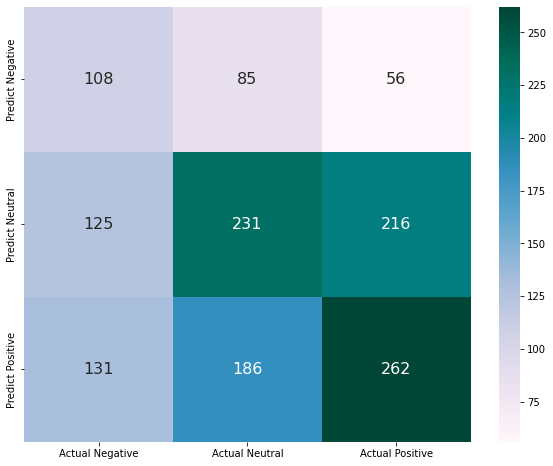

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))

cm = confusion_matrix(y_test, y_pred_test)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='PuBuGn', annot_kws={"fontsize":16})
plt.show()

# Logistic Regression

In [35]:
lr = LogisticRegression(random_state=123).fit(X_train_scaled, y_train)

y_pred_train = lr.predict(X_train_scaled)
y_pred_test = lr.predict(X_test_scaled)

print("Training Accuracy score: "+str(round(accuracy_score(y_train,dt.predict(X_train_scaled)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,dt.predict(X_test_scaled)),4)))

Training Accuracy score: 1.0
Testing Accuracy score: 0.5879


In [36]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.78      0.57      0.66       249
     neutral       0.57      0.60      0.59       572
    negative       0.64      0.68      0.66       579

    accuracy                           0.63      1400
   macro avg       0.66      0.62      0.63      1400
weighted avg       0.64      0.63      0.63      1400



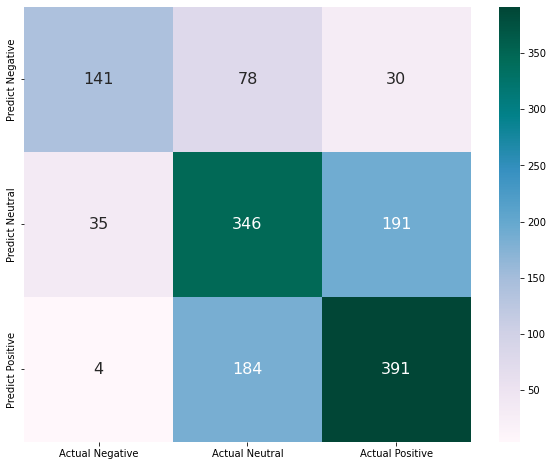

In [37]:
# Matriz de confusão
fig, ax = plt.subplots(figsize=(10, 8))

cm = confusion_matrix(y_test, y_pred_test)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])

# Heatmap
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='PuBuGn', annot_kws={"fontsize":16})
plt.show()

# Random Forest Classifier

In [38]:
clf = RandomForestClassifier()

clf.fit(X_train_scaled, y_train)

y_pred_train = clf.predict(X_train_scaled)
y_pred_test = clf.predict(X_test_scaled)

print("Training Accuracy score: "+str(round(accuracy_score(y_train,dt.predict(X_train_scaled)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,dt.predict(X_test_scaled)),4)))

Training Accuracy score: 1.0
Testing Accuracy score: 0.5879


In [39]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.93      0.49      0.64       249
     neutral       0.62      0.72      0.66       572
    negative       0.70      0.73      0.71       579

    accuracy                           0.68      1400
   macro avg       0.75      0.65      0.67      1400
weighted avg       0.71      0.68      0.68      1400



<AxesSubplot:>

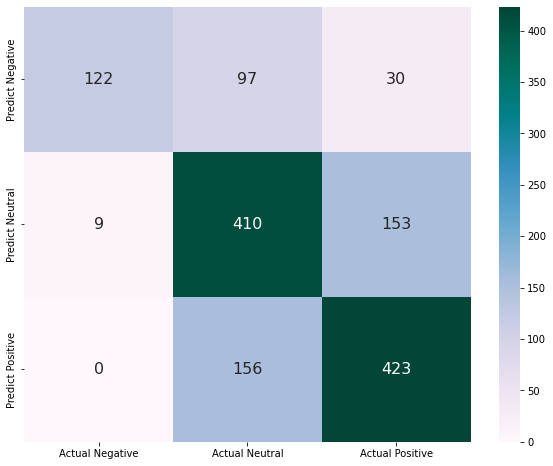

In [40]:
# Matriz de confusão
fig, ax = plt.subplots(figsize=(10, 8))

cm = confusion_matrix(y_test, y_pred_test)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])

# Heatmap
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='PuBuGn', annot_kws={"fontsize":16})

# Ensembling

In [41]:
classifiers = [('Decision Tree', dt),
               ('Logistic Regression', lr),
               ('Naive Bayes', gnb),
               ("Random Forest", clf)
              ]
vc = VotingClassifier(estimators=classifiers)
vc.fit(X_train_scaled, y_train)

print("Training Accuracy score: "+str(round(accuracy_score(y_train, y_pred_train), 4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test, y_pred_test), 4)))

Training Accuracy score: 1.0
Testing Accuracy score: 0.6821


In [43]:
predictions = pd.Series(lr.predict(X), name="sentiment")
results = pd.concat([predictions],axis=1)
results.to_csv("trip-advisor-review-sentiment.csv",index=False)

# Conclusão

Podemos observar o desempenho de diversos modelos sendo implementado juntamente com uma análise comparativa de várias métricas.

**1.** Os modelos Naïve Bayes e Decision Tree possuem um desempenho inferior em relação aos outros modelos. Ambos tiveram uma baixa acurácia de teste e f1-score.

**2.** Os modelos de Logistic Regression e Random Forest Classifier apresentaram uma performance razoável na acurácia de teste. O primeiro (Logistic Regression) apresentou um f1-score razoável, já o segundo (Random Forest Classificer) apresentou um bom  f1-score.  

 **3.** O modelo Ensembling teve um desempenho razoável na acurácia de teste, porém o f1-score ficou baixo.  

A partir das considerações acima recomendo o modelo **Random Forest Classifier**.

A análise de sentimentos pode ser aplicada de diversas maneiras, desde monitoramento de marca e análise de produtos, até atendimento ao cliente e pesquisa de mercado. A sua aplicação torna o trabalho mais rápido e preciso em diração aos objetivos do negócio. Ela permite entender melhor os clientes e a apartir desse entendimento é possível treinar de forma mais eficaz as equipes.